# mesoSPIM PSF-analysis

## Experiment setup
- mesoSPIM V5 detection system: Olympus MVPLAPO-1x, zoom 4X
- Hamamatsu Orca Flash 4v3 camera
- 1 um Fluoresbrite YG Microspheres beads mounted in 1% agarose and RIMS (n1.45) molded as cylinders
- cylinder in a quartz cuvette is immersed in RI-matched medium (n1.45) large cuvette
- thickness of RIMS medium in detection path unknown

Modified version of Supp Fig. 4 published in [Voigt et al, 2019](https://www.nature.com/articles/s41592-019-0554-0)

In [1]:
import numpy as np
import pandas as pd
from skimage.io import imread, find_available_plugins
import time

In [2]:
from psf import plotPSF, getCenters, getPSF

### Setup plotting

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')

In [4]:
from ipywidgets import interact
from ipywidgets import IntSlider

### Define parameters

`windowUm = [15, 15, 15]` defines a "window" volume in microns in which only a single bead can exist (for the bead to be included in the analysis, the volume has to contain a single bright maximum).

In [5]:
# Full FOV 
MAG = 4 # Nominal magniciation of te objective
TL_f_mm = 200 # TL focal distante (200 or 180 mm)
eff_MAG = MAG * TL_f_mm/200
UmPerPxLat = 6.5/eff_MAG
pxPerUmLat = 1/UmPerPxLat
pxPerUmAx = 1.0 # between z-planes
windowUm = [15, 15, 15] # 
options = {'pxPerUmLat':pxPerUmLat, 'pxPerUmAx':pxPerUmAx, 'windowUm':windowUm}
options['thresh'] = 700 #changed to abs, was relative: (0.05) 
options

{'pxPerUmLat': 0.6153846153846154,
 'pxPerUmAx': 1.0,
 'windowUm': [15, 15, 15],
 'thresh': 700}

In [6]:
datafolder = "D://benchtopData//PSF//Fabian-V5-resolution//1to10000_4x_test//"
LENS_NAME = f"Olympus MVPLAPO-1x, zoom 4X"
CAMERA = "Hamamatsu Orca Flash 4v3"
sensor_dim_mm = (13.312, 13.312) 
freq_Hz = 199.9
exp_ms = 5
wf_ms = 250
experiment_key = f"{MAG}X_ETL-on-f{freq_Hz}Hz-exp{exp_ms}ms-wf{wf_ms}ms" 
datafiles = {
    "4X_ETL-on-f199.9Hz-exp5ms-wf250ms": datafolder + f"5ms_2nd_488_nm_508_520-35_4x_Right_first300.tif",
}
experiment_key

'4X_ETL-on-f199.9Hz-exp5ms-wf250ms'

### Load data

In [7]:
im = imread(datafiles[experiment_key], plugin='tifffile')[:200]
print(im.shape)
FOV_Y_um, FOV_X_um = im.shape[1] * UmPerPxLat, im.shape[2] * UmPerPxLat
print(FOV_Y_um, FOV_X_um)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


(200, 2048, 2048)
3328.0 3328.0


### Computation

In [8]:
start_time = time.time()
beads, maxima, centers, smoothed = getCenters(im, options)
stop_time = time.time()
print('Runtime: ',stop_time-start_time, ' s')

findBeads() done: 3535 found
centersM done
centerDists done
keepBeads() done: 3143 found
getCenters() done: 3143 found
Runtime:  205.14445781707764  s


In [9]:
start_time = time.time()
data = [getPSF(x, options) for x in beads]
stop_time = time.time()
print('Runtime: ',stop_time-start_time, ' s')

Runtime:  7.782849311828613  s


C:\Users\Nikita\anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [10]:
centers = pd.DataFrame(centers, columns=['Z','Y','X'])

In [11]:
PSF = pd.concat([x[0] for x in data])
PSF['Max'] = maxima
PSF = PSF.reset_index().drop(['index'],axis=1)
latProfile = [x[1] for x in data]
axProfile = [x[2] for x in data]
PSF = PSF.join(centers)

### Inspect results

In [12]:
PSF.head()

,FWHMlat,FWHMax,Max,Z,Y,X
0,4.360692,5.754993,36321,108,344,423
1,2.889623,5.354437,48662,39,1046,673
2,3.603982,5.828847,39279,173,538,582
3,3.933159,6.152971,32542,125,579,394
4,2.985883,3.905164,32704,82,1659,1835


In [13]:
print('# Beads: ', len(PSF))
print('\nMedian lateral FWHM (+/- std): ', round(np.median(PSF['FWHMlat']),2), ' +/- ', round(PSF['FWHMlat'].std(),2), ' μm')
print(f"MIN, MAX lateral FWHM: {round(PSF['FWHMlat'].min(),2)}, {round(PSF['FWHMlat'].max(),2)} μm")
print('\nMedian axial FWHM  (+/- std): ', round(np.nanmedian(PSF['FWHMax']),2), ' +/- ', round(PSF['FWHMax'].std(),2), ' μm')
print(f"MIN, MAX axial FWHM: {round(PSF['FWHMax'].min(),2)}, {round(PSF['FWHMax'].max(),2)}, μm")

print('\nWatch for large STD (>2 um), they indicate bad detections, e.g. multiple beads merged together.')

# Beads:  3143

Median lateral FWHM (+/- std):  2.72  +/-  31.54  μm
MIN, MAX lateral FWHM: -1424.57, 1045.85 μm

Median axial FWHM  (+/- std):  5.06  +/-  1.45  μm
MIN, MAX axial FWHM: 1.52, 37.74, μm

Watch for large STD (>2 um), they indicate bad detections, e.g. multiple beads merged together.


### Plot axial FWHM vs. FOV

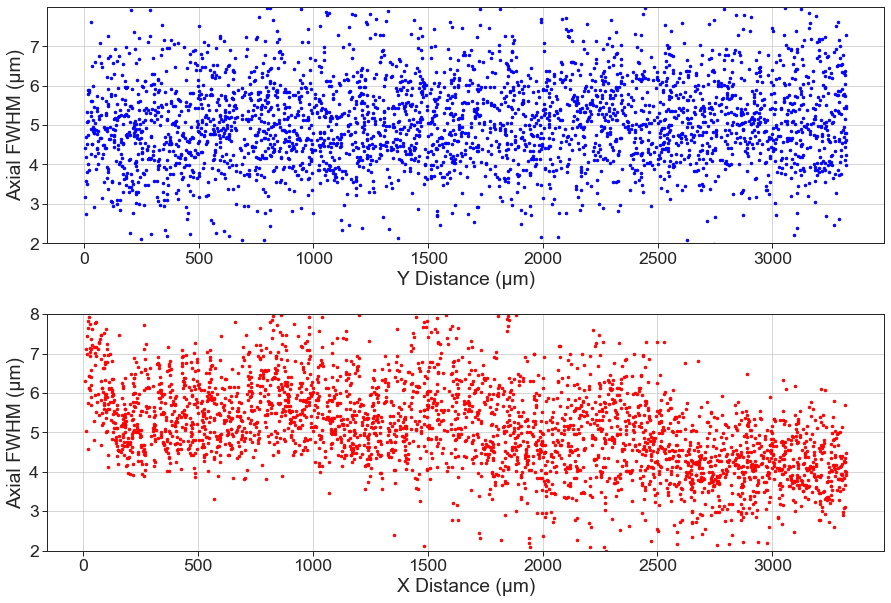

In [14]:
%matplotlib inline
YMIN, YMAX = 2, 8
fig = plt.figure(figsize=(15,10));

subfigure0 = fig.add_subplot(211)
subfigure0.plot(np.multiply(PSF['Y'].tolist(),UmPerPxLat),PSF['FWHMax'].tolist(),'.b',ms=5)
subfigure0.set_ylim([YMIN,YMAX])
subfigure0.set_yticks(range(YMIN, YMAX))
subfigure0.set_xlabel('Y Distance (μm)')
subfigure0.set_ylabel('Axial FWHM (μm)')
subfigure0.grid()

subfigure1 = fig.add_subplot(212)
subfigure1.plot(np.multiply(PSF['X'].tolist(),UmPerPxLat),PSF['FWHMax'].tolist(),'.r',ms=5)
subfigure1.set_ylim([YMIN,YMAX])
subfigure1.set_xlabel('X Distance (μm)')
subfigure1.set_ylabel('Axial FWHM (μm)')
subfigure1.grid()

plt.subplots_adjust(hspace = 0.3)

In [15]:
fig.savefig(datafolder + f'/{experiment_key}-{exp_ms}ms-{freq_Hz}hz-axialFWHM-along-axes.svg', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)
fig.savefig(datafolder + f'/{experiment_key}-{exp_ms}ms-{freq_Hz}hz-axialFWHM-along-axes.png', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)

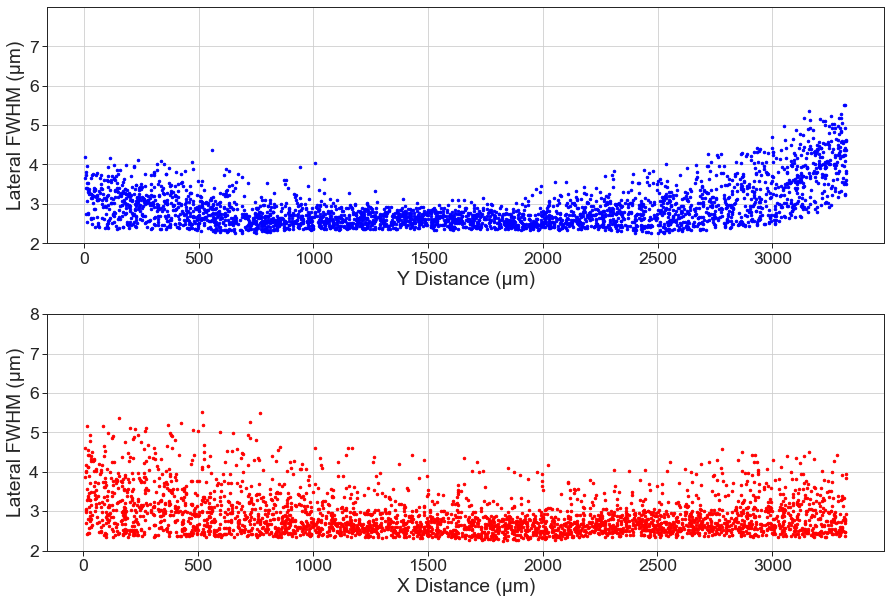

In [16]:
%matplotlib inline
YMIN, YMAX = 2, 8
fig = plt.figure(figsize=(15,10));

subfigure0 = fig.add_subplot(211)
subfigure0.plot(np.multiply(PSF['Y'].tolist(),UmPerPxLat),PSF['FWHMlat'].tolist(),'.b',ms=5)
subfigure0.set_ylim([YMIN,YMAX])
subfigure0.set_yticks(range(YMIN, YMAX))
subfigure0.set_xlabel('Y Distance (μm)')
subfigure0.set_ylabel('Lateral FWHM (μm)')
subfigure0.grid()

subfigure1 = fig.add_subplot(212)
subfigure1.plot(np.multiply(PSF['X'].tolist(),UmPerPxLat),PSF['FWHMlat'].tolist(),'.r',ms=5)
subfigure1.set_ylim([YMIN,YMAX])
subfigure1.set_xlabel('X Distance (μm)')
subfigure1.set_ylabel('Lateral FWHM (μm)')
subfigure1.grid()

plt.subplots_adjust(hspace = 0.3)

In [17]:
fig.savefig(datafolder + f'/{experiment_key}-{exp_ms}ms-{freq_Hz}hz-lateralFWHM-along-axes.svg', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)
fig.savefig(datafolder + f'/{experiment_key}-{exp_ms}ms-{freq_Hz}hz-lateralFWHM-along-axes.png', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)

In [18]:
PSF.to_csv(datafolder + f'/{experiment_key}-{exp_ms}ms-{freq_Hz}hz.csv')

## Sanity checks

### Plot max projection and detected beads

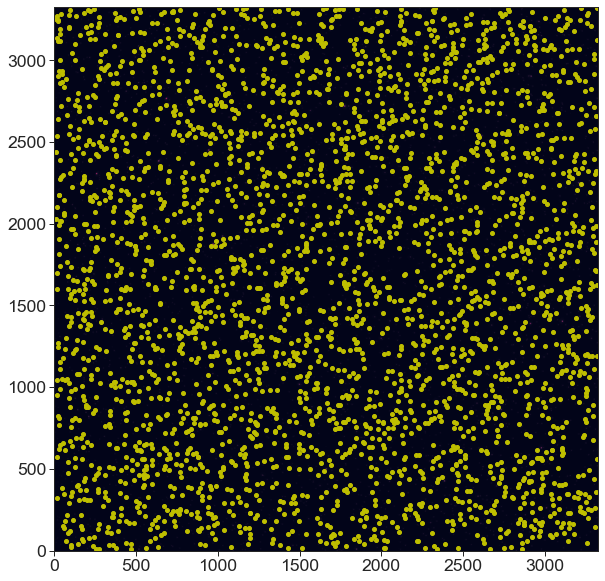

In [19]:
plt.figure(figsize=(10,10));
plt.imshow(smoothed, extent=(0, FOV_X_um, 0, FOV_Y_um))
plt.plot((PSF['X']*UmPerPxLat).tolist(), (PSF['Y']*UmPerPxLat).tolist(), 'y.', ms=8);
#plt.axis('off'); 

### Axial and lateral FWHM Histogram

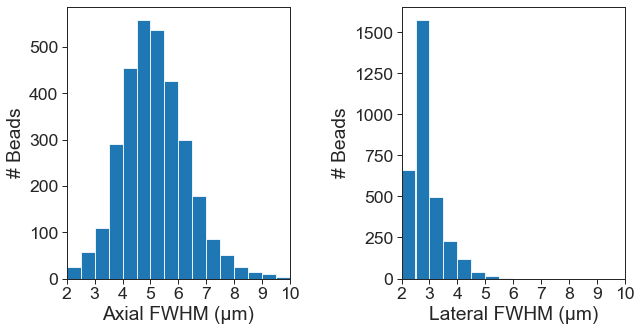

In [20]:
fig = plt.figure(figsize=(10,5))
subfigure0 = fig.add_subplot(121)
subfigure0.hist(PSF['FWHMax'].tolist(),2*8,range=(2,10))
subfigure0.set_xlim([2, 9])
subfigure0.set_xlabel('Axial FWHM (μm)')
subfigure0.set_xticks(range(2,11))
subfigure0.set_ylabel('# Beads')
subfigure1 = fig.add_subplot(122)
subfigure1.hist(PSF['FWHMlat'].tolist(),2*8,range=(2,10))
subfigure1.set_xlim([2, 9])
subfigure1.set_xticks(range(2,11))
subfigure1.set_xlabel('Lateral FWHM (μm)')
subfigure1.set_ylabel('# Beads')

plt.subplots_adjust(wspace = 0.5)

In [21]:
fig.savefig(datafolder + f'/{experiment_key}-{exp_ms}ms-{freq_Hz}hz-hist-axial-lateral.svg', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)
fig.savefig(datafolder + f'/{experiment_key}-{exp_ms}ms-{freq_Hz}hz-hist-axial-lateral.png', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)

In [75]:
# manually exclude detections that are double-beads next to each other, see manual PSF check below
#exclude_IDs = [929, 2193]
#PSF_cleaned = PSF.drop(exclude_IDs)

### Overview Plots

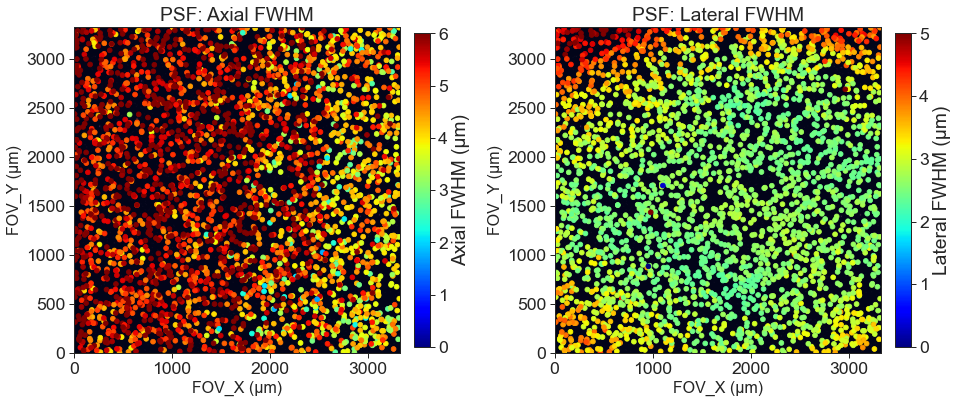

In [26]:
fig = plt.figure(figsize=(15,7.5));
cmap = 'jet'

subfigure0 = fig.add_subplot(121)
subfigure0.imshow(smoothed, extent=(0, FOV_X_um, 0, FOV_Y_um))
overlay0 = subfigure0.scatter((PSF['X']*UmPerPxLat).tolist(), (PSF['Y']*UmPerPxLat).tolist(), c=PSF['FWHMax'].tolist(), 
                              cmap=cmap, vmin=0, vmax=6)
subfigure0.axis('on');
subfigure0.set_title('PSF: Axial FWHM')
subfigure0.set_ylabel('FOV_Y (μm)', fontsize=16)
subfigure0.set_xlabel('FOV_X (μm)', fontsize=16)
cbar0 = plt.colorbar(overlay0,fraction=0.044, pad=0.04)
cbar0.set_label('Axial FWHM (μm)')


subfigure1 = fig.add_subplot(122)
subfigure1.imshow(smoothed, extent=(0, FOV_X_um, 0, FOV_Y_um));
overlay1 = subfigure1.scatter((PSF['X']*UmPerPxLat).tolist(), (PSF['Y']*UmPerPxLat).tolist(), c=PSF['FWHMlat'].tolist(), cmap=cmap, vmin=0, vmax=5);
subfigure1.axis('on');
subfigure1.set_title('PSF: Lateral FWHM')
subfigure1.set_ylabel('FOV_Y (μm)', fontsize=16)
subfigure1.set_xlabel('FOV_X (μm)', fontsize=16)
cbar1 = plt.colorbar(overlay1,fraction=0.044, pad=0.04)
cbar1.set_label('Lateral FWHM (μm)')

plt.subplots_adjust(wspace = 0.35)

In [27]:
fig.savefig(datafolder + f'/{experiment_key}-{exp_ms}ms-{freq_Hz}hz-Comparision-XYplot-jet-vmax5.svg', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)
fig.savefig(datafolder + f'/{experiment_key}-{exp_ms}ms-{freq_Hz}hz-Comparision-XYplot-jet-vmax5.png', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)

## Plot XYZ projections of selected PSFs and fit

In [28]:
centerPSFs = PSF[PSF.FWHMlat > 4.5]
centerPSFs.head()

,FWHMlat,FWHMax,Max,Z,Y,X
66,5.508122,4.794135,11786,185,2041,319
241,4.658771,7.522451,6729,137,2017,55
436,5.095028,6.007286,6733,184,1981,138
488,4.925232,5.738412,6311,67,2041,148
1308,4.520618,4.613363,6827,112,1919,399


In [ ]:
len(centerPSFs)

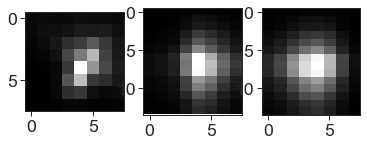

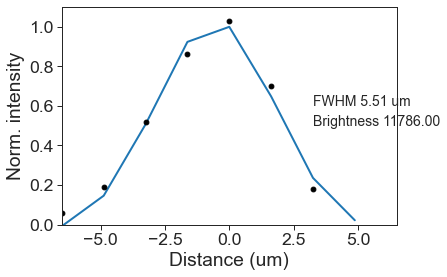

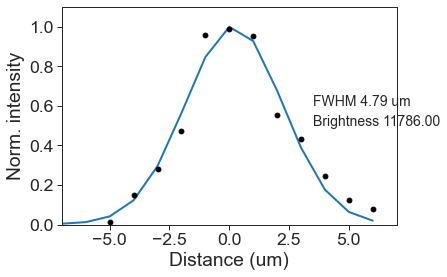

In [29]:
# Plot PSF with known ID
beadInd = 66
average = beads[beadInd]

fig, _axs = plt.subplots(nrows=1, ncols=3)
axs = _axs.flatten()

XYview = axs[0].imshow(average.mean(axis=0), cmap='gray');
XZview = axs[1].imshow(average.mean(axis=1), aspect = pxPerUmLat/pxPerUmAx, cmap='gray');
YZview = axs[2].imshow(average.mean(axis=2), aspect = pxPerUmLat/pxPerUmAx, cmap='gray');
plt.show()

plotPSF(latProfile[beadInd][0],latProfile[beadInd][1],latProfile[beadInd][2],latProfile[beadInd][3],pxPerUmLat,PSF.Max.iloc[beadInd])
plt.show()
plotPSF(axProfile[beadInd][0],axProfile[beadInd][1],axProfile[beadInd][2],axProfile[beadInd][3],pxPerUmAx,PSF.Max.iloc[beadInd])
plt.show()